In [1]:
from six.moves import cPickle
import os
import matplotlib.pyplot as plt
import numpy as np
import importlib
import utils as ut
from tqdm import tqdm
import mlp_bonus as mlp

Using TensorFlow backend.


In [7]:
K, d, n = 10, 3072, 10000
np.random.seed(42)
mu, sigma = 0, 0.01 
batch_start, batch_end= 0, 20

# Data Preprocessing

In [2]:
def normalize_data(X, mean, std):
    X -= np.outer(mean_X, np.ones(X.shape[1]))
    X /= np.outer(std_X, np.ones(X.shape[1]))
    return X
    
importlib.reload(ut)
X_train, y_train, Y_train = ut.loadData('data_batch_1', clipping=True)
X_val, y_val, Y_val = ut.loadData('data_batch_2', clipping=True)
X_test, y_test, Y_test = ut.loadData('test_batch', clipping=True)

## normalize with mean and std of train set 
mean_X = np.mean(X_train, axis=1)
std_X = np.std(X_train, axis=1)

X_train = normalize_data(X_train, mean_X, std_X)
X_val = normalize_data(X_val, mean_X, std_X)
X_test = normalize_data(X_test, mean_X, std_X)

# Ensemble Learning + Cyclical Learning

 33%|███▎      | 16/48 [00:35<01:03,  2.00s/it]Cycle 0 saved
Update Step 0: train_acc=0.6452 | val_acc=0.4591 | train_loss=1.0966245081408244 | val_loss=1.5953886034315605 | train_cost=1.4132763946092082 | val_cost=1.9120404898999444
 67%|██████▋   | 32/48 [01:10<00:31,  1.99s/it]Cycle 1 saved
Update Step 0: train_acc=0.6924 | val_acc=0.462 | train_loss=0.9767353437675818 | val_loss=1.5990891864017185 | train_cost=1.3627454075888425 | val_cost=1.9850992502229792
100%|██████████| 48/48 [01:46<00:00,  2.21s/it]Cycle 2 saved



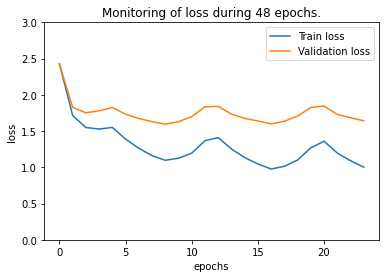

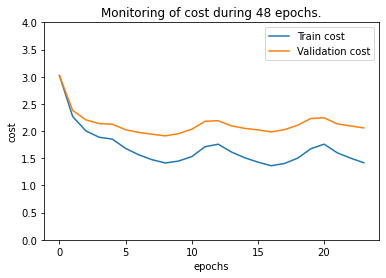

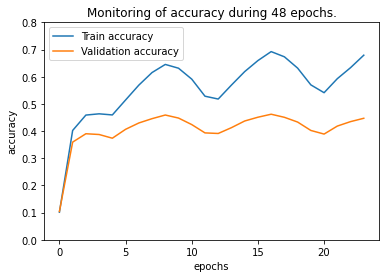

In [10]:
importlib.reload(mlp)
net2 = mlp.MLP(lamda=.01)
GDparams = {"n_batch":100, "n_epochs":48, "eta_min":1e-5, "eta_max":1e-1, "ns":800}
net2.cyclicLearning(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparams, verbose=True, freq=8, backup=True, experiment="ensemble_learning")
net2.plot_metric(GDparams, metric="loss")
net2.plot_metric(GDparams, metric="cost")
net2.plot_metric(GDparams, metric="accuracy")

In [11]:
net2.computeAccuracy(X_test, y_test)

0.4576

In [42]:
importlib.reload(mlp)
net2 = mlp.MLP(lamda=.01)
GDparams = {"n_batch":100, "n_epochs":48, "eta_min":1e-5, "eta_max":1e-1, "ns":800}
classes, acc = net2.majorityVoting(X_test, y_test, GDparams, n_cycle=3, experiment="ensemble_learning")
acc

0.4576

# WHOLE DATA

In [26]:
importlib.reload(ut)
X_train_whole, y_train_whole, Y_train_whole = ut.loadData('data_batch_1', clipping=True)
X_test, y_test, Y_test = ut.loadData('test_batch', clipping=True)

for i in range(2,6):
    X, y, Y = ut.loadData('data_batch_'+str(i), clipping=True)
    X_train_whole = np.concatenate((X, X_train_whole), axis=1)
    y_train_whole = np.concatenate((y, y_train_whole))
    Y_train_whole = np.concatenate((Y, Y_train_whole), axis=1)

n_val = 5000

X_val_small, y_val_small, Y_val_small = X_train_whole[:,-n_val:], y_train_whole[-n_val:], Y_train_whole[:,-n_val:]
X_train_whole, y_train_whole, Y_train_whole = X_train_whole[:,:-n_val], y_train_whole[:-n_val], Y_train_whole[:,:-n_val]

## normalize with mean and std of train set 
mean = np.mean(X_train_whole, axis=1)
std = np.std(X_train_whole, axis=1)

X_train_whole = normalize_data(X_train_whole, mean, std)
X_val_small = normalize_data(X_val_small, mean, std)
X_test = normalize_data(X_test, mean_X, std_X)

# Estimate Boundaries

In [3]:
importlib.reload(mlp)
net = mlp.MLP()
etas, accuracies = net.estimateBoundaries(X_train, Y_train, y_train,  X_val, Y_val, y_val, eta_min=0.0001, eta_max=0.02, n_search=10, h=50, lamda=0.01)

100%|██████████| 10/10 [00:32<00:00,  3.27s/it]


No handles with labels found to put in legend.


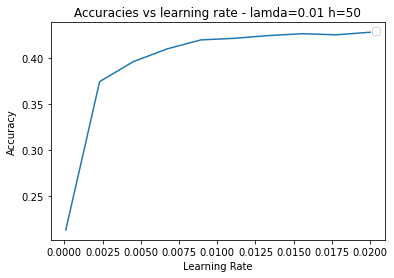

In [4]:
net.plotAccuracies(etas, accuracies, lamda=0.01, h=50)

In [5]:
etas

array([0.0001    , 0.00231111, 0.00452222, 0.00673333, 0.00894444,
       0.01115556, 0.01336667, 0.01557778, 0.01778889, 0.02      ])